# IMPORTANTE!!!!!
Cambiar nombre de los archivos si se quiere guardar resultaados

In [9]:
import csv
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras import optimizers
from keras import losses
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.models import load_model, Model
from keras.layers import Input, LSTM, SimpleRNN, GRU, Dense, Dropout, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer
import math
from math import sqrt
import h5py

In [2]:
#De csv a array
train = pd.read_csv(r'C:\Users\Jaime\Desktop\TFG\Experimento1\3_data.csv').values
print (train.shape)
print (train)

(2399, 5)
[[4.2394000e+01 1.0000000e-01 4.4008000e+01 4.2932000e+01 1.4000000e+09]
 [4.2932000e+01 0.0000000e+00 4.7236000e+01 4.5622000e+01 1.4000000e+09]
 [4.2394000e+01 4.3799877e+01 4.7774000e+01 4.6160000e+01 1.4000000e+09]
 ...
 [4.3470000e+01 5.7000430e+01 4.6160000e+01 4.1856000e+01 6.0000000e+08]
 [4.4008000e+01 6.1200102e+01 4.5084000e+01 4.1856000e+01 6.0000000e+08]
 [4.3470000e+01 5.1799971e+01 4.3470000e+01 4.1856000e+01 6.0000000e+08]]


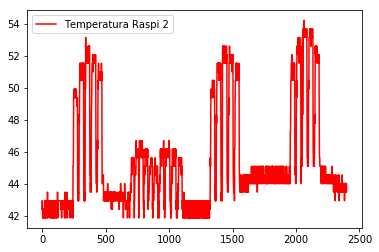

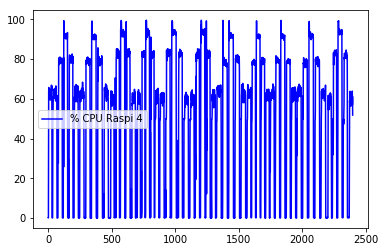

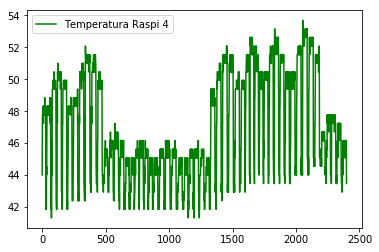

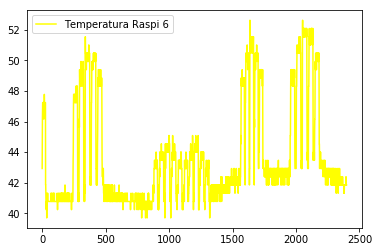

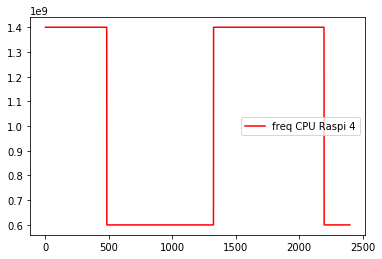

In [3]:
# Visualising the Data
plt.plot(train[:,0], color='red', label='Temperatura Raspi 2')
plt.legend()
plt.show()
plt.plot(train[:,1], color='blue', label='% CPU Raspi 4')
plt.legend()
plt.show()
plt.plot(train[:,2], color='green', label='Temperatura Raspi 4')
plt.legend()
plt.show()
plt.plot(train[:,3], color='yellow', label='Temperatura Raspi 6')
plt.legend()
plt.show()
plt.plot(train[:,4], color='red', label='freq CPU Raspi 4')
plt.legend()
plt.show()

In [4]:
# defining the batch size and number of epochs
batch_size = 95
epochs = 120
timesteps = 3
porcentaje_test = 0.12

In [5]:
length = len(train)
print (length)
length *= 1 - porcentaje_test
print (length)

2399
2111.12


In [2]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [7]:
length = get_train_length(train, batch_size, porcentaje_test)
print (length)

2090
2090


In [8]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = train[0:upper_train]
print(df_data_1_train.shape)
training_set = df_data_1_train
training_set.shape

(2096, 5)


(2096, 5)

In [9]:
# Feature Scaling
    #Valores entre 0 y 1

from sklearn.preprocessing import StandardScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled= sc.fit_transform(training_set)
'''
training_set_scaled_1 = sc.fit_transform(np.float64(training_set[:,0:1]))
training_set_scaled_2 = sc.fit_transform(np.float64(training_set[:,1:2]))
training_set_scaled_3 = sc.fit_transform(np.float64(training_set[:,2:3]))
training_set_scaled_4 = sc.fit_transform(np.float64(training_set[:,3:4]))

train_plot_tmp = np.append(training_set_scaled_1, training_set_scaled_2, axis=1)
train_plot_tmp = np.append(train_plot_tmp, training_set_scaled_3, axis=1)
training_set_scaled = np.append(train_plot_tmp, training_set_scaled_4, axis=1)
'''

print (training_set_scaled.shape)
print (training_set_scaled)

#p = r'C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\'
#aaa= p + "train.csv"
#np.savetxt(aaa, training_set_scaled, delimiter=",")

(2096, 5)
[[0.04347826 0.00100402 0.2173913  0.25       1.        ]
 [0.08695652 0.         0.47826087 0.45833333 1.        ]
 [0.04347826 0.43975881 0.52173913 0.5        1.        ]
 ...
 [0.30434783 0.         0.26086957 0.29166667 1.        ]
 [0.26086957 0.00100402 0.2173913  0.33333333 1.        ]
 [0.26086957 0.         0.26086957 0.25       1.        ]]


In [10]:
X_train_0 = []
X_train_1 = []
X_train_2 = []
X_train_3 = []
X_train_4 = []

y_train_0 = []


# Creating a data structure with n timesteps

print ('tamaño de datos mas ventana: '+str(length + timesteps))
for i in range(timesteps, length + timesteps): 
    X_train_0.append(training_set_scaled[i-timesteps:i,0])
    X_train_1.append(training_set_scaled[i-timesteps:i,1])
    X_train_2.append(training_set_scaled[i-timesteps:i,2])
    X_train_3.append(training_set_scaled[i-timesteps:i,3])
    X_train_4.append(training_set_scaled[i-timesteps:i,4])
    y_train_0.append(training_set_scaled[i:i+timesteps,2]) #Coge temperatura Raspi 4 - column 3


tamaño de datos mas ventana: 2093


In [11]:
X_train_0, y_train_0, X_train_1, = np.array(X_train_0), np.array(y_train_0), np.array(X_train_1)
X_train_2, X_train_3, X_train_4 = np.array(X_train_2), np.array(X_train_3), np.array(X_train_4)

X_train_0 = np.reshape(X_train_0, (X_train_0.shape[0], X_train_0.shape[1], 1))
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))
X_train_3 = np.reshape(X_train_3, (X_train_3.shape[0], X_train_3.shape[1], 1))
X_train_4 = np.reshape(X_train_4, (X_train_4.shape[0], X_train_4.shape[1], 1))

y_train = np.reshape(y_train_0, (y_train_0.shape[0], y_train_0.shape[1], 1))


train_plot_tmp = np.append(X_train_0, X_train_1, axis=2)
train_plot_tmp = np.append(train_plot_tmp, X_train_2, axis=2)
train_plot_tmp = np.append(train_plot_tmp, X_train_3, axis=2)
X_train = np.append(train_plot_tmp, X_train_4, axis=2)


print (X_train.shape)
print (y_train.shape)
print (X_train)
#print (y_train)


(2090, 3, 5)
(2090, 3, 1)
[[[0.04347826 0.00100402 0.2173913  0.25       1.        ]
  [0.08695652 0.         0.47826087 0.45833333 1.        ]
  [0.04347826 0.43975881 0.52173913 0.5        1.        ]]

 [[0.08695652 0.         0.47826087 0.45833333 1.        ]
  [0.04347826 0.43975881 0.52173913 0.5        1.        ]
  [0.04347826 0.63855534 0.52173913 0.54166667 1.        ]]

 [[0.04347826 0.43975881 0.52173913 0.5        1.        ]
  [0.04347826 0.63855534 0.52173913 0.54166667 1.        ]
  [0.         0.65964181 0.52173913 0.58333333 1.        ]]

 ...

 [[0.39130435 0.92670699 0.95652174 0.375      1.        ]
  [0.30434783 0.9176795  0.47826087 0.29166667 1.        ]
  [0.30434783 0.45984039 0.30434783 0.29166667 1.        ]]

 [[0.30434783 0.9176795  0.47826087 0.29166667 1.        ]
  [0.30434783 0.45984039 0.30434783 0.29166667 1.        ]
  [0.30434783 0.00200804 0.30434783 0.33333333 1.        ]]

 [[0.30434783 0.45984039 0.30434783 0.29166667 1.        ]
  [0.30434783 

In [12]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,5))
lstm_1_mae = GRU(4, stateful=False, return_sequences=True, activation='selu')(inputs_1_mae)
#lstm_1_mae = SimpleRNN(256, stateful=True, return_sequences=True)(inputs_1_mae)
#lstm_2_mae = Dropout(0.2)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_1_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

optimizer_elegido = 'optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)'
opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
loss_elegido = 'losses.mean_absolute_error'
loss_ = losses.mean_absolute_error

regressor_mae.compile(optimizer=opt, loss = loss_, metrics =['accuracy'])
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (95, 3, 5)                0         
_________________________________________________________________
gru_1 (GRU)                  (95, 3, 4)                120       
_________________________________________________________________
dense_1 (Dense)              (95, 3, 1)                5         
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


In [13]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
2090/2090 [==============================] - 0s 219us/step - loss: 0.6482 - acc: 0.0018
Epoch: 1
Epoch 1/1
2090/2090 [==============================] - 0s 34us/step - loss: 0.3284 - acc: 0.0019
Epoch: 2
Epoch 1/1
2090/2090 [==============================] - 0s 23us/step - loss: 0.2007 - acc: 0.0019
Epoch: 3
Epoch 1/1
2090/2090 [==============================] - 0s 23us/step - loss: 0.1842 - acc: 0.0019
Epoch: 4
Epoch 1/1
2090/2090 [==============================] - 0s 23us/step - loss: 0.1731 - acc: 0.0019
Epoch: 5
Epoch 1/1
2090/2090 [==============================] - 0s 23us/step - loss: 0.1632 - acc: 0.0019
Epoch: 6
Epoch 1/1
2090/2090 [==============================] - 0s 23us/step - loss: 0.1541 - acc: 0.0019
Epoch: 7
Epoch 1/1
2090/2090 [==============================] - 0s 21us/step - loss: 0.1457 - acc: 0.0019
Epoch: 8
Epoch 1/1
2090/2090 [==============================] - 0s 19us/step - loss: 0.1378 - acc: 0.0019
Epoch: 9
Epoch 1/1
2090/2090 [===============

In [14]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [15]:
test_length = get_test_length(train, batch_size)
print("test length: "+str(test_length))
upper_test = test_length + timesteps*2
print("upper test: "+str(upper_test))
print("upper train: "+str(upper_train))
testset_length = test_length - upper_train
print ("test set length: "+str(testset_length))

2286
2381
test length: 2381
upper test: 2387
upper train: 2096
test set length: 285


In [16]:
# construct test set

#subsetting
test_set = train[upper_train:upper_test, 0:5]
print("maximo: " + str(max(test_set[:,2])))
print("minimo: " + str(min(test_set[:,2])))
#print(test_set.shape)

#Escalado OJO poner la ultima la que predigaaaas
training_set_scaled_1 = sc.fit_transform(np.float64(test_set[:,0:1]))
training_set_scaled_2 = sc.fit_transform(np.float64(test_set[:,1:2]))
training_set_scaled_4 = sc.fit_transform(np.float64(test_set[:,3:4]))
training_set_scaled_5 = sc.fit_transform(np.float64(test_set[:,4:5]))
training_set_scaled_3 = sc.fit_transform(np.float64(test_set[:,2:3]))

train_plot_tmp = np.append(training_set_scaled_1, training_set_scaled_2, axis=1)
train_plot_tmp = np.append(train_plot_tmp, training_set_scaled_3, axis=1)
train_plot_tmp = np.append(train_plot_tmp, training_set_scaled_4, axis=1)
scaled_real_bcg_values_test = np.append(train_plot_tmp, training_set_scaled_5, axis=1)

X_test_0 = []
X_test_1 = []
X_test_2 = []
X_test_3 = []
X_test_4 = []
Y_test_evaluate = []

# Creating a data structure with n timesteps

for i in range(timesteps, testset_length + timesteps): 
    X_test_0.append(scaled_real_bcg_values_test[i-timesteps:i,0])
    X_test_1.append(scaled_real_bcg_values_test[i-timesteps:i,1])
    X_test_2.append(scaled_real_bcg_values_test[i-timesteps:i,2])
    X_test_3.append(scaled_real_bcg_values_test[i-timesteps:i,3])
    X_test_4.append(scaled_real_bcg_values_test[i-timesteps:i,4])
    Y_test_evaluate.append(scaled_real_bcg_values_test[i:i+timesteps,2])

X_test_0, X_test_1, X_test_2, X_test_3, X_test_4 = np.array(X_test_0), np.array(X_test_1), np.array(X_test_2), np.array(X_test_3), np.array(X_test_4)
Y_test_evaluate = np.array(Y_test_evaluate)

X_test_0 = np.reshape(X_test_0, (X_test_0.shape[0], X_test_0.shape[1], 1))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))
X_test_3 = np.reshape(X_test_3, (X_test_3.shape[0], X_test_3.shape[1], 1))
X_test_4 = np.reshape(X_test_4, (X_test_4.shape[0], X_test_4.shape[1], 1))

train_plot_tmp = np.append(X_test_0, X_test_1, axis=2)
train_plot_tmp = np.append(train_plot_tmp, X_test_2, axis=2)
train_plot_tmp = np.append(train_plot_tmp, X_test_3, axis=2)
X_test = np.append(train_plot_tmp, X_test_4, axis=2)

Y_test_evaluate = np.reshape(Y_test_evaluate, (Y_test_evaluate.shape[0], Y_test_evaluate.shape[1], 1))

print(X_test.shape)


maximo: 52.61600000000001
minimo: 42.931999999999995
(285, 3, 5)


In [17]:
#prediction
predicted_bcg_values_test_mse = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print (predicted_bcg_values_test_mse.shape)

#reshaping

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
print (predicted_bcg_values_test_mse.shape)

#inverse transform
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)


#creating y_test data
y_test = []
y_test_2 = []
y_test_3 = []
y_test_4 = []
y_test_5 = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mse[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print (y_test.shape)

(285, 3, 1)
(285, 3)
(282, 1)


In [18]:
#Si se quiere guardar los resultados
import datetime
guardar_archivos = 1 #A 1 para guardar
path = r'C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\'
#OJO CAMBIAR nombre
nombre_para_archivo = "SimpleRNN_Dropout"
now = datetime.datetime.now()
fecha_para_archivo = str(now.hour) + "_" + str(now.minute) + " " + str(now.day) + "-" + str(now.month)
nombre = path + nombre_para_archivo + " " + fecha_para_archivo

C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\SimpleRNN_Dropout 21_34 25-6.png


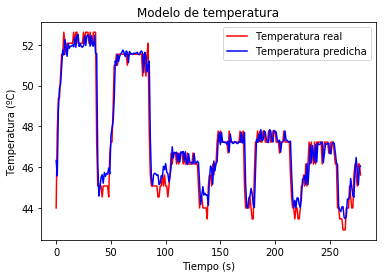

In [19]:
# Vemos los resultados:
#Datos reales sacados de los datos del test (de la ventana hasta el final del set menos la ventana ya que le añadimos x2 ventanas) 
plt.plot(test_set[timesteps:len(y_test), 2], color = 'red', label = 'Temperatura real')
#Datos predichos sacados de la prediccion(de 0 a el final menos la ventana) 
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Temperatura predicha')
plt.title('Modelo de temperatura')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (ºC)')
plt.legend()

if(guardar_archivos==1):
    fichero_png = nombre + ".png"  
    print (fichero_png)
    plt.savefig(fichero_png)

plt.show()


In [20]:
#Métricas 
real = test_set[timesteps:len(y_test),2]
real = np.reshape(real, (real.shape[0]))
print(real.shape)
predicha = y_test[0:len(y_test) - timesteps]
predicha = np.reshape(predicha, (predicha.shape[0]))
print(predicha.shape)
diferencia = []
rel_err_temp=0
max_rel_temp = []
rmsd_temp = 0
for i in range(len(y_test) - timesteps):
    diferencia.append(abs(predicha[i] - real[i]))
    
maximo=np.amax(diferencia)
STD=np.std(diferencia)
MSE=mean_squared_error(real, predicha)
RMSD=sqrt(mean_squared_error(real, predicha))
MAE=mean_absolute_error(real, predicha)
R2=r2_score(real, predicha) 

for j in range(len(diferencia)):
    rel_err_temp += abs(100*(real[j]-predicha[j])/real[j])

rel_err=(rel_err_temp)/len(diferencia)

for t in range(len(diferencia)):
    max_rel_temp.append(abs(100*(real[t]-predicha[t])/real[t]))

max_rel = np.amax(max_rel_temp)

print("MAE: " + str(MAE))
print(" ±")
print("STD: " + str(STD))
print("MAPE: " + str(rel_err) + " %")
print("R^2: " + str(100*R2) + " %")
print("MáxAE: " + str(maximo))
print("MáxAPE: " + str(max_rel) + " %")
print("RMSD: " + str(RMSD))
#print("Error cuadrático medio: " + str(MSE))


(279,)
(279,)
MAE: 0.5047924104642701
 ±
STD: 0.5328389132893788
MAPE: 1.0833992489923876 %
R^2: 92.83822885573308 %
MáxAE: 4.324634613037105
MáxAPE: 9.15537855245386 %
RMSD: 0.7339841177966553


In [21]:
#Métricas del test
model_evalute = regressor_mae.evaluate(X_test, Y_test_evaluate, batch_size=batch_size)
print(model_evalute[0])
print(model_evalute[1])

285/285 [==============================] - 0s 198us/step
0.07991527269283931
0.05263157809774081


In [22]:
#Guardar txt con info de la red
import os
if (guardar_archivos==1):
    
    comentario = ""

    fichero_txt = nombre + ".txt"
    print (fichero_txt)

    file = open(fichero_txt ,"w") 

    file.write("Tamaño de los datos al principio: " + str(train.shape) + "\n") 

    file.write("Batch_size: " + str(batch_size) + "\n") 

    file.write("Epochs: " + str(epochs) + "\n") 

    file.write("Porcentaje de test: " + str(porcentaje_test) + "\n") 

    file.write("Timesteps: " + str(timesteps) + "\n") 
    
    file.write("Optimizer elegido: " + optimizer_elegido + "\n") 

    file.write("Loss elegida: " + loss_elegido + "\n")   

    regressor_mae.summary(print_fn=lambda x: file.write(x + '\n'))

    file.write("\n") 
    
    file.write("MAE ± STD: " + str(round(MAE,3)) + " ± " + str(round(STD,3)) + " ºC \n")
    
    file.write("MAPE: " + str(round(rel_err,3)) + " % \n")
    
    file.write("R^2 : " + str(round((100*R2),3)) + " % \n")
    
    file.write("MáxAE: " + str(round(maximo,3)) + " ºC \n")
    
    file.write("MáxAPE: " + str(round(max_rel,3)) + " % \n")    
    
    file.write("RMSD : " + str(round(RMSD,3)) + " ºC \n")
    
    #file.write("MSE: " + str(MSE) + "\n")

    file.write("Comentario: " + comentario + "\n") 

    file.close()

    path_tmp = r'C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\'
    tmp = path_tmp + nombre_para_archivo + " " + fecha_para_archivo + ".txt"
    print (tmp)
    os.rename(tmp, fichero_txt) 
    
    name_real=path_tmp + "real " + fecha_para_archivo + ".csv"
    name_predicha=path_tmp + "predicha " + fecha_para_archivo + ".csv"
    np.savetxt(name_real, real, delimiter=",")
    np.savetxt(name_predicha, predicha, delimiter=",")
    

C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\SimpleRNN_Dropout 21_34 25-6.txt
C:\Users\Jaime\Desktop\TFG\Experimento1\Resultados\\SimpleRNN_Dropout 21_34 25-6.txt


In [23]:
#guardar modelo en json y h5
if(guardar_archivos==1):
    fichero_json = nombre + ".json"
    model_json_prueba = regressor_mae.to_json()
    with open(fichero_json, "w") as json_file:
        json_file.write(model_json_prueba)
    fichero_h5 = nombre + ".h5"
    regressor_mae.save(filepath=fichero_h5)